## Playground for selecting subset of frames to train GNN.

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as functional
from torch_geometric.data import Batch, Data, DataLoader

from collab_env.data.file_utils import expand_path, get_project_root

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

from utility import handle_discrete_data

from collab_env.data.boids.animal_simulation import visualize_graph

In [17]:
smoke_test = "CI" in os.environ

save_file = True if not smoke_test else False

In [15]:
import matplotlib.animation as animation


def visualize_graph(
    p,
    v,
    e=None,
    extra_title=None,
    batch=None,
    starting_frame=0,
    file_id=0,
    model=None,
    device=None,
):
    """ """
    model = model.to(device) if model else None

    if batch is not None:
        p, species = batch
        p = p[file_id]

    p0 = p[starting_frame]
    N = p0.shape[0]
    print("p0 shape", p0.shape)
    print("p shape", p.shape)
    colors = ["C" + str(n % 10) for n in range(N)]

    # Create the figure and axes
    fig, axes = plt.subplots(2, 1, figsize=(5, 7), height_ratios=(3, 1))

    # Set plot limits
    ax = axes[0]
    ax_extra = axes[1]
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Initialization function: plot the background of each frame
    def init():
        ax.scatter(p0[:, 0], p0[:, 1], color=colors)
        if e is not None:
            ax_extra.plot(e[0, :], color="k")
        if v is not None:
            ax.quiver(
                p0[:, 0],
                p0[:, 1],
                v[starting_frame, :, 0] * 10,
                v[starting_frame, :, 1] * 10,
                color=colors,
                scale_units="xy",
                scale=1,
                alpha=0.5,
            )
        # ax.plot([pos[0]+vel[0],pos[0]+vel[0]],[pos[0]+vel[0],pos[0]+vel[0]])

    def animate(i):
        ax.clear()
        ax_extra.clear()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.scatter(p[i, :, 0], p[i, :, 1], color=colors)
        if e is not None:
            ax_extra.plot(e[:i, :], color="k")
            ax_extra.stem(i - 1, e[i - 1, 0], markerfmt="ro")
        if v is not None:
            ax.quiver(
                p[i, :, 0],
                p[i, :, 1],
                v[i + 1, :, 0] * 10,
                v[i + 1, :, 1] * 10,
                scale_units="xy",
                scale=1,
            )
        ax.set_title("Frame" + str(i))
        if ax_extra is not None:
            ax_extra.set_title(extra_title)
            ax_extra.set_xlabel("frames")

    ani = animation.FuncAnimation(
        fig,
        animate,
        init_func=init,
        frames=np.arange(starting_frame + 1, p.shape[0] - 1),
        interval=5,
        repeat=False,
        blit=False,
    )

    # To save the animation as a GIF (requires ImageMagick or Pillow)
    # ani.save('flocking_test.gif', writer='imagemagick', fps=30)

    plt.show()
    return ani, ax

In [6]:
file_name = "boid_single_species_basic.pt"
config_name = "boid_single_species_basic_config.pt"

dataset = torch.load(
    expand_path("simulated_data/runpod/" + file_name, get_project_root()),
    weights_only=False,
)
species_configs = torch.load(
    expand_path("simulated_data/runpod/" + config_name, get_project_root()),
    weights_only=False,
)

# create mini-batches
batch_size = 1
# right now we assume the batch_size = 1, because our real dataset are of different lengths.
# But we can expand to minibatches - except fpr a few specific functions, every function is written with minibatches in mind.
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

/workspace/conda/envs/gnn/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
file_id = 2

In [8]:
batch = list(iter(train_loader))[file_id]
position, species = batch

pos, vel, acc, v_function = handle_discrete_data(position, "Euler")
print("position data shape", pos[0].shape)

position data shape torch.Size([800, 20, 2])


In [9]:
# construct lazy model prediction error
actual = pos[:, 1:]
predicted = pos[:, :-1] + vel[:, :-1]
loss = [
    functional.mse_loss(actual[:, f], predicted[:, f]) for f in range(actual.shape[1])
]

# polarity
polarity = torch.norm(torch.mean(vel[0], axis=1), dim=1)
polarity_diff = torch.diff(polarity)

In [10]:
extra_plot = np.hstack(
    (polarity_diff.numpy().reshape((-1, 1)), np.array(loss).reshape((-1, 1)))
)

p0 shape torch.Size([20, 2])
p shape torch.Size([800, 20, 2])


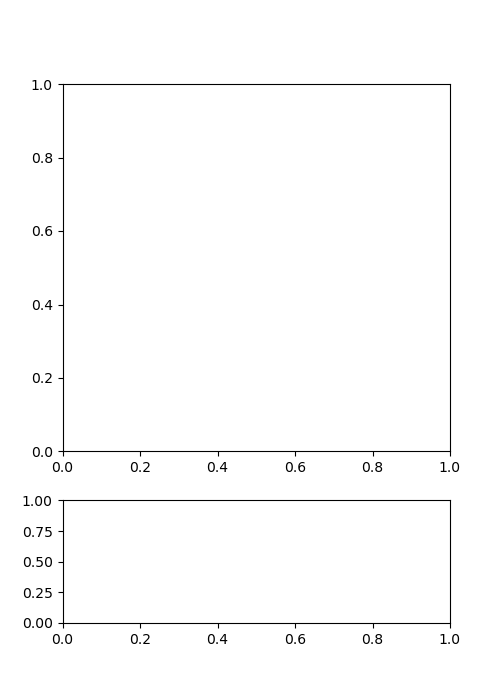

In [16]:
%matplotlib widget
ani, ax = visualize_graph(
    pos[0],
    vel[0],
    extra_plot,
    extra_title="velocity polarization difference",
    batch=None,
    starting_frame=0,
    file_id=1,
)

In [86]:
if save_file:
    ani.save("boid_boundary_long.gif", writer="pillow", fps=20)

/tmp/ipykernel_61579/2629561390.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(np.abs(polarity_diff), label = "abs polarity change")
/tmp/ipykernel_61579/2629561390.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mean = torch.mean(np.abs(polarity_diff))
/tmp/ipykernel_61579/2629561390.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sd = torch.std(np.abs(polarity_diff))


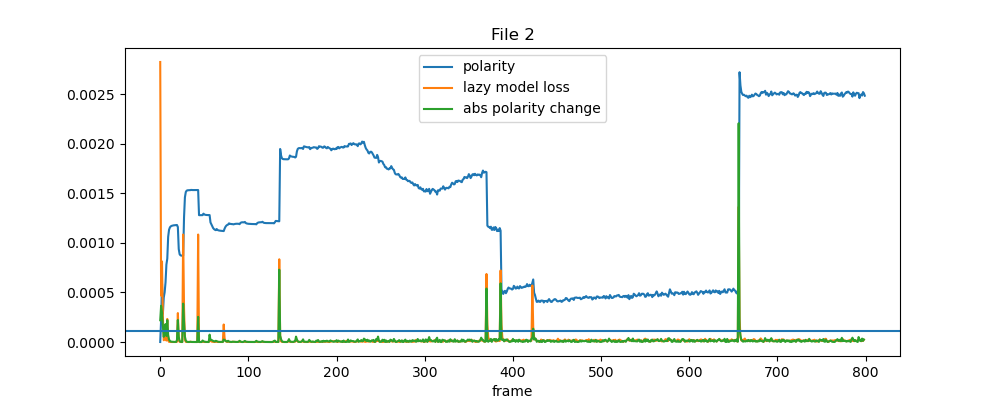

In [18]:
# polarity
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(polarity, label="polarity")
plt.plot(np.array(loss) * 100, label="lazy model loss")
plt.plot(np.abs(polarity_diff), label="abs polarity change")
mean = torch.mean(np.abs(polarity_diff))
sd = torch.std(np.abs(polarity_diff))
ax.axhline(mean + sd)

ax.set_xlabel("frame")
ax.set_title("File " + str(file_id))
plt.legend()
plt.show()

In [19]:
from collab_env.gnn.gnn import identify_frames

In [20]:
frames = identify_frames(pos, vel)

In [21]:
np.argwhere(np.abs(polarity_diff) >= mean + sd)

/tmp/ipykernel_61579/2077923172.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.argwhere(np.abs(polarity_diff) >= mean + sd)


tensor([[  0,   1,   2,   3,   6,   8,  20,  26,  27,  43, 135, 370, 386, 423,
         656, 657]])